In [1]:
import nltk
import pandas
from bs4 import BeautifulSoup as bs
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [ ]:
'''
Points Headings:
    Explanation of the data
    Preparing the data
    Models
    Result Interpretation
'''

# Explanation of the data

This dataset was downloaded from kaggle.com (https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data).  The dataset contains a list of tweets directed at airlines, whether the tweet was negative, positive, or neutral, and other various attributes.  In order to gather the tweets, Twitter was scraped and contributors were asked to classify the tweet as negative, neutral, or positive, as well as give an explanation for any negative tweets.  A subset of this data was used for this project.  The data was reduced to the positive/negative/neutral column, and the text of the tweet.  In total, there are 14640 tweets.  This project is a classification problem. I am going to try to predict whether a tweet directed at an airline was negative, positive, or neutral. 

In [3]:
data = pandas.read_csv("Tweets.csv")

In [4]:
#here is what the data looks like
data = data[['airline_sentiment', 'text']] # use a subset of the data
data.head() #show what the subset data set we are going to use looks like

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
#show how much data we have
len(data) 

14640

In [6]:
#show how much positive, negative, and neutral data we have
positive_data = data[data.airline_sentiment=='positive']
negative_data = data[data.airline_sentiment=='negative']
neutral_data = data[data.airline_sentiment=='neutral']

print("Number of positive tweets:", len(positive_data))
print("Number of negative tweets:", len(negative_data))
print("Number of neutral tweets:", len(neutral_data))

Number of positive tweets: 2363
Number of negative tweets: 9178
Number of neutral tweets: 3099


In [7]:
#an example of a tweet's text
print(data['text'][12])

@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p


# Preparing the data

First, we took a subset of the data that consisted of only the sentiment analysis attribute and text attribute.  I only wanted to do a text analysis so I only used these two features.  Next, all of the words that started with @ were removed from the tweet.  The @s were attached to the airline and I thought the airline could have an impact on the analysis of the tweet.  For example, if American Airlines received lots of positive tweets, the model might assume that a new tweet containing @AmericanAir is positive just because it has their twitter handle in the text.  Next, I replaced all characters that were not a letter or an apostrophe with a space.  This would allow words like can’t and don’t to be stored, but delete all other punctuation.  Next, all letters were converted to lower case.  This will ensure that same words with difference upper and lower casing are treated the same. Lastly, all stopwords, or words that don’t carry much meaning were removed from the text.  This ensures that the text we are using holds meaning, and we don’t have to look at words that wouldn’t add much benefit to our classification decision.

# Functions and variable setups

In [8]:
#function to remove @words, remove unwanted characters and convert all letters to lower case
def clean_text(tweet):
    tweet_words_wo_stopwords = []
    tweet_no_at = ' '.join(filter(lambda word:word[0]!='@', tweet.split())) #filter out words that start with @
    tweet_limited_characters = re.sub("[^a-z'A-Z]", " ", tweet_no_at) #substitute any character that isnt a-z or A-Z with " "
    all_lower = tweet_limited_characters.lower() #make all words lowercase
    list_of_words =  all_lower.split() #turn the string into a list of words
    for word in list_of_words:
        if word not in stopwords.words("english"):
            tweet_words_wo_stopwords.append(word)
    clean_tweet = " ".join(tweet_words_wo_stopwords)
    return clean_tweet

In [9]:
#a function to show accuracies in a clean way
def clean_display(accuracy):
    return round(accuracy*10000.00)/100.00

In [10]:
#the amount of reviews we will be using
NUMBER_OF_REVIEWS = len(data)

In [11]:
#a list of cleaned tweets
list_of_cleaned_tweets = []
for index in range(len(data["text"][:NUMBER_OF_REVIEWS])):
    list_of_cleaned_tweets.append(clean_text(data["text"][index]))

In [12]:
#split the data into training and testing sets
(train_tweets, test_tweets, train_target, test_target) = \
train_test_split(list_of_cleaned_tweets, data["airline_sentiment"][:NUMBER_OF_REVIEWS],\
test_size = 0.2)

In [13]:
#bag of words with 500 most common words
vectorizer500 = CountVectorizer(analyzer='word', max_features = 500)
#find the right 5000 words
vectorizer500.fit(train_tweets)
#look at which words it found
print(vectorizer500.get_feature_names())

['aa', 'able', 'account', 'actually', 'add', 'agent', 'agents', 'ago', 'air', 'airline', 'airlines', 'airport', 'airways', 'almost', 'already', 'also', 'always', 'amazing', 'american', 'amp', 'another', 'answer', 'anyone', 'anything', 'app', 'appreciate', 'around', 'arrive', 'arrived', 'ask', 'asked', 'assistance', 'attendant', 'attendants', 'available', 'away', 'awesome', 'awful', 'back', 'bad', 'bag', 'baggage', 'bags', 'bc', 'believe', 'best', 'better', 'big', 'board', 'boarding', 'book', 'booked', 'booking', 'bos', 'boston', 'bring', 'broken', 'business', 'bwi', 'call', 'called', 'calling', 'calls', 'can', 'cancelled', 'cannot', 'car', 'card', 'care', 'carry', 'chance', 'change', 'changed', 'changes', 'charge', 'charlotte', 'check', 'checked', 'checking', 'chicago', 'claim', 'class', 'clt', 'club', 'co', 'come', 'coming', 'company', 'confirmation', 'connecting', 'connection', 'contact', 'cool', 'cost', 'could', 'couldn', 'credit', 'crew', 'cust', 'customer', 'customers', 'dallas', 

In [14]:
#transform tweet strings into the rows of word counts
#also convert it to a numpy array so we can later feed it to a machine learning algorithm
train_word_columns500 = vectorizer500.transform(train_tweets).toarray()
test_word_columns500 = vectorizer500.transform(test_tweets).toarray()

#look at what train_words_columns looks like
print(train_word_columns500)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [15]:
extractor500 = PCA(n_components=500, whiten=True)
extractor500.fit(train_word_columns500)
print('this is the variance/importance of each component')
print(extractor500.explained_variance_ratio_)

this is the variance/importance of each component
[  4.87316755e-02   2.63982742e-02   1.67329719e-02   1.60954420e-02
   1.41804085e-02   1.18745865e-02   1.08698241e-02   1.04236131e-02
   9.57117228e-03   9.37541504e-03   9.25011762e-03   8.23740309e-03
   7.86231407e-03   7.79872740e-03   7.33839365e-03   7.31794637e-03
   7.10610371e-03   6.93767211e-03   6.77261905e-03   6.74869655e-03
   6.63140079e-03   6.50899876e-03   6.42302532e-03   6.35025163e-03
   6.13901808e-03   5.99194209e-03   5.83378739e-03   5.73755882e-03
   5.52684883e-03   5.40521432e-03   5.25555833e-03   5.18279560e-03
   5.05320381e-03   4.98792635e-03   4.87675604e-03   4.77167458e-03
   4.66901472e-03   4.64209324e-03   4.55186109e-03   4.49144040e-03
   4.44602135e-03   4.37764694e-03   4.30986883e-03   4.28362399e-03
   4.20182179e-03   4.17239774e-03   4.12275570e-03   4.10314982e-03
   4.07303101e-03   4.03276568e-03   3.96087652e-03   3.94353556e-03
   3.86607875e-03   3.83539032e-03   3.81484387e-03  

In [16]:
train_transformed500 = extractor500.transform(train_word_columns500)
test_transformed500 = extractor500.transform(test_word_columns500)
train_transformed500

array([[ -5.16127316e-01,  -2.74498771e-01,  -7.77085319e-02, ...,
         -2.17455160e-02,   3.73753726e-02,   1.22784840e-01],
       [ -4.10943112e-01,  -3.85781253e-01,  -4.59358881e-01, ...,
          1.10732755e-01,   8.93409475e-04,   1.34748843e-01],
       [  1.10659837e+00,  -3.03562872e-01,   3.56159497e+00, ...,
          3.09317741e-01,   1.26712601e-02,  -4.60690043e-01],
       ..., 
       [  1.22661538e+00,   5.20119201e-02,   2.84579746e-01, ...,
          2.10474634e-01,   4.76521592e-02,   4.21748638e-02],
       [ -5.12163459e-01,  -3.38137234e-01,  -1.52640992e-01, ...,
         -2.57258178e-01,  -3.54102589e-02,   5.18832449e-02],
       [  1.34486258e+00,  -2.04927116e-01,  -1.74084511e+00, ...,
          8.90815828e-02,   5.64897283e-02,   1.69526540e-01]])

# Models

Model 1 is a multinomial naive bayes model with default parameters.  It uses 500 of the most common words to interpret the text.  

In [17]:
#MODEL 1

#Basic multinomial Naive Bayes
multinomialNaiveBayes = MultinomialNB()
multinomialNaiveBayes.fit(train_word_columns500, train_target)
predictions1 = multinomialNaiveBayes.predict(test_word_columns500)
print(clean_display(accuracy_score(predictions1, test_target))) 

73.19


Model 2 is a support vector machine/ support vector classifier.  It also uses 500 of the most common words to interpret the text.

In [18]:
#MODEL 2

#Basic SVM
supportVectorClassifier = SVC()
supportVectorClassifier.fit(train_word_columns500, train_target)
predictions2 = supportVectorClassifier.predict(test_word_columns500)
print(clean_display(accuracy_score(predictions2, test_target)))

66.87


Model 3 is a gaussian naive bayes model thats uses data that has been transformed through PCA.  The PCA uses 500 components and uses the frequency of the 500 most common words to create a transformed array that we use to fit the model.  A gaussian model is used because the multinomial naive bayes model cannot handle the negative values in the transformed data.  

In [19]:
#MODEL 3

#Basic naive bayes with PCA
#using Gaussian b/c there are negative values in the transformed data which multinomial cant handle
gnb_pca = GaussianNB()
gnb_pca.fit(train_transformed500, train_target)
gnb_pca_predictions1 = gnb_pca.predict(test_transformed500)
print('Accuracy:',clean_display(accuracy_score(gnb_pca_predictions1, test_target)))

Accuracy: 58.13


Model 4 is a SVM model thats uses data that has been transformed through PCA. The PCA uses 500 components and uses the frequency of the 500 most common words to create a transformed array that we use to fit the model.

In [20]:
#MODEL 4

#Basic SVM with PCA
supportVectorClassifier_pca = SVC()
supportVectorClassifier_pca.fit(train_transformed500, train_target)
svm_pca_predictions1 = supportVectorClassifier_pca.predict(test_transformed500)
print(clean_display(accuracy_score(svm_pca_predictions1, test_target)))

75.2


# Additional Training

Model 5 is the best SVM I could find.  I did a series of grid searches in order to find this model.  The grid searchs have been ommitted to increase the time to run the notebook because the time to run the notebook took too long when I needed to make changes.  C, gamma, and kernel were adjusted to find this model and the parameter tests cant be found at the bottom of the notebook.  This model does not use PCA, just the regular frequency array of the most common 500 words. 

In [21]:
#MODEL 5

#Better SVM model without PCA
best_svc = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
best_svc.fit(train_word_columns500, train_target)
best_svc_predictions = best_svc.predict(test_word_columns500)
print(clean_display(accuracy_score(best_svc_predictions, test_target)))

75.48


This model is the same as the one above but uses PCA.

In [22]:
#MODEL 6

#SVM model with PCA
supportVectorClassifier_pca = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
supportVectorClassifier_pca.fit(train_transformed500, train_target)
svm_pca_predictions500 = supportVectorClassifier_pca.predict(test_transformed500)
print(clean_display(accuracy_score(svm_pca_predictions500, test_target)))

67.01


The models below use a new bag of words that has 1000 words and the PCA uses 1000 components instead of the 500 we were using before.

In [23]:
#going to use more words to see if it helps
#bag of words with 1000 most common words
vectorizer1000 = CountVectorizer(analyzer='word', max_features = 1000)
#find the right 1000 words
vectorizer1000.fit(train_tweets)
#look at which words it found
#print(vectorizer1000.get_feature_names())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [24]:
#transform review strings into the rows of word counts
#also convert it to a numpy array so we can later feed it to a machine learning algorithm
train_word_columns1000 = vectorizer1000.transform(train_tweets).toarray()
test_word_columns1000 = vectorizer1000.transform(test_tweets).toarray()

#look at what train_words_columns looks like
#print(train_word_columns1000)

In [25]:
#an extractor with 1000 components, in the above models we used 500 components
extractor1000 = PCA(n_components=1000, whiten=True)
extractor1000.fit(train_word_columns1000)
#print('this is the variance/importance of each component')
#print(extractor1000.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [26]:
train_transformed1000 = extractor1000.transform(train_word_columns1000)
test_transformed1000 = extractor1000.transform(test_word_columns1000)
#train_transformed1000

Model 7 is the same as model 1 but uses the new bag of words with 1000 words.  It does not use PCA.

In [27]:
#MODEL 7

#Basic multinomial Naive Bayes
multinomialNaiveBayes1000 = MultinomialNB()
multinomialNaiveBayes1000.fit(train_word_columns1000, train_target)
mnb_predictions1000 = multinomialNaiveBayes1000.predict(test_word_columns1000)
print(clean_display(accuracy_score(mnb_predictions1000, test_target))) 

74.69


Model 8 uses the gaussian naive bayes with the new bag of words and the new PCA with 1000 components

In [28]:
#MODEL 8

#Basic naive bayes with PCA
#using Gaussian b/c there are negative values in the transformed data which multinomial cant handle
gnb_pca1000 = GaussianNB()
gnb_pca1000.fit(train_transformed1000, train_target)
gnb_pca_predictions1000 = gnb_pca1000.predict(test_transformed1000)
print('Accuracy:',clean_display(accuracy_score(gnb_pca_predictions1000, test_target)))

Accuracy: 58.13


Model 9 is a SVM that uses the new PCA with 1000 components.

In [29]:
#MODEL 9

#Basic SVM with PCA
supportVectorClassifier_pca1000 = SVC()
supportVectorClassifier_pca1000.fit(train_transformed1000, train_target)
svm_pca_predictions1000 = supportVectorClassifier_pca1000.predict(test_transformed1000)
print(clean_display(accuracy_score(svm_pca_predictions1000, test_target)))

75.41


Model 10 is the best SVM model again but with the new 1000 bag of words.  Since this model did the best with 500 words and 500 components in the PCA, I wanted to see if it would do better with more words and components.

In [30]:
#MODEL 10

#the best SVM model without PCA, but with 1000 words
svc1000 = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svc1000.fit(train_word_columns1000, train_target)
svc1000_predictions = svc1000.predict(test_word_columns1000)
print(clean_display(accuracy_score(svc1000_predictions, test_target)))

76.98


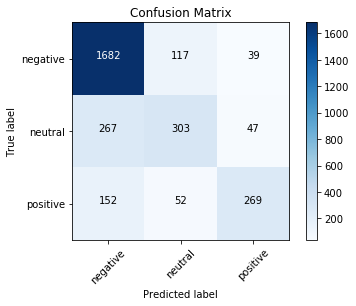

In [31]:
#a confustion matrix create from the best model
#the best model was a SVM wihout PCA, and the 1000 bag of words
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

cm=metrics.confusion_matrix(test_target, svc1000_predictions)
plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1,2], svc1000.classes_,rotation=45)
plt.yticks([0,1,2], svc1000.classes_)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.0f'), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Additional Training with a new subset of the data

The data contains many more negative tweets that positive tweets.  I wanted to give the model a dataset with an even split of negative, positve, and neutral tweets.  So I made a new list of tweets to be used for analysis that had an equal number of positive, negative, and neutral tweets.  I setup all the necessary variables to run the best model from the code above to see if that model would do better with this modified dataset.

In [32]:
NUMBER_OF_EVEN_REVIEWS = min(len(positive_data), len(negative_data), len(neutral_data))*3
print(NUMBER_OF_EVEN_REVIEWS)

7089


In [34]:
even_list_of_cleaned_reviews = []
for index in range(int(len(data["text"][:NUMBER_OF_EVEN_REVIEWS])/3)):
    even_list_of_cleaned_reviews.append(clean_text(positive_data["text"].iloc[index]))
    even_list_of_cleaned_reviews.append(clean_text(negative_data["text"].iloc[index]))
    even_list_of_cleaned_reviews.append(clean_text(neutral_data["text"].iloc[index]))

In [35]:
(even_train_tweets, even_test_tweets, even_train_target, even_test_target) = \
train_test_split(even_list_of_cleaned_reviews, data["airline_sentiment"][:NUMBER_OF_EVEN_REVIEWS],\
test_size = 0.2)

In [36]:
#bag of words with 500 most common words
even_vectorizer1000 = CountVectorizer(analyzer='word', max_features = 1000)
#find the right 5000 words
even_vectorizer1000.fit(even_train_tweets)
#look at which words it found
#print(even_vectorizer1000.get_feature_names())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [37]:
#transform review strings into the rows of word counts
#also convert it to a numpy array so we can later feed it to a machine learning algorithm
even_train_word_columns1000 = even_vectorizer1000.transform(even_train_tweets).toarray()
even_test_word_columns1000 = even_vectorizer1000.transform(even_test_tweets).toarray()

#look at what train_words_columns looks like
#print(even_train_word_columns1000)

Model 11 is the best model from above but with the new special even subset of data

In [38]:
#MODEL 11

#using the best model from above with an even split dataset
even_svc1000 = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
even_svc1000.fit(even_train_word_columns1000, even_train_target)
even_svc1000_predictions = svc1000.predict(even_test_word_columns1000)
print(clean_display(accuracy_score(even_svc1000_predictions, even_test_target)))

47.74


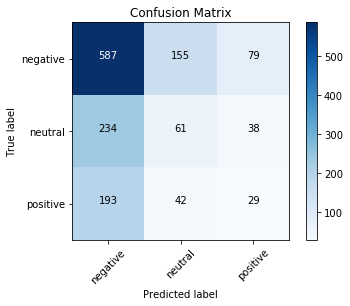

In [39]:
even_cm=metrics.confusion_matrix(even_test_target, even_svc1000_predictions)
plt.imshow(even_cm, interpolation='nearest',cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1,2], even_svc1000.classes_,rotation=45)
plt.yticks([0,1,2], even_svc1000.classes_)
thresh = even_cm.max() / 2.
for i, j in itertools.product(range(even_cm.shape[0]), range(even_cm.shape[1])):
    plt.text(j, i, format(even_cm[i, j], '.0f'), horizontalalignment="center",color="white" if even_cm[i, j] > thresh else "black")
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Result Interpretation

Overall the SVM with C=1.0, gamma=0.1, and kernel=rbf performed the best with 1000 words in the bag of words and without PCA.  Fine tuning model parameters added some increase in accuracy to the model but usually around 1%.  I found that playing with the size of the bag of words and the number of components in the PCA model had the greatest effect on the accuracy.  I thought the model was not performing better than 80% accuracy because it saw a greater number of negative tweets than the other two categories.  I tried to fix this by creating a subset of the data with an even amount of positive, negative, and neutral tweets.  I used this new dataset with the best model that used the unchange dataset and found worse results.  Because I had an even number of tweets in each category, I had to reduce the number of tweets used overall which may have caused the new model with the special dataset to perform worse.  If the dataset was larger, this could have worked better.  Additionally, using all tweets, not just ones directed at airlines, could have been used to train our model and might have yielded better accuracy.  I believe any tweet could be used because tweets with negative sentiment about anything will be similar to tweets with negative sentiment towards airlines.  

# Parameters used to find the best SVM

In [40]:
#list of parameters used with gridsearch to find a better svc model
'''
svc_parameters1 = {'C':[0.1, 1, 10],
             'kernel':['rbf', 'linear', 'poly'],
             'gamma':[0.1, 1, 10]}

svc_parameters2 = {'kernel':['rbf', 'linear', 'poly']}

svc_parameters3 = {'C':[10,100],
             'kernel':['rbf'],
             'gamma':[0.01, 0.1]}

svc_parameters4 = {'C':[10, 12, 14],
             'kernel':['rbf'],
             'gamma':[0.1]}

svc_parameters5 = {'C':[6,8,10],
             'kernel':['rbf'],
             'gamma':[0.1]}

svc_parameters6 = {'C':[4,5,6,7,8],
             'kernel':['rbf'],
             'gamma':[0.1]}

svc_parameters7 = {'C':[6.5, 7, 7.5],
             'kernel':['rbf'],
             'gamma':[0.1]}

svc_parameters8 = {'C':[7],
             'kernel':['rbf'],
             'gamma':[0.01, 0.05,0.1, 0.2]}
'''

"\nsvc_parameters1 = {'C':[0.1, 1, 10],\n             'kernel':['rbf', 'linear', 'poly'],\n             'gamma':[0.1, 1, 10]}\n\nsvc_parameters2 = {'kernel':['rbf', 'linear', 'poly']}\n\nsvc_parameters3 = {'C':[10,100],\n             'kernel':['rbf'],\n             'gamma':[0.01, 0.1]}\n\nsvc_parameters4 = {'C':[10, 12, 14],\n             'kernel':['rbf'],\n             'gamma':[0.1]}\n\nsvc_parameters5 = {'C':[6,8,10],\n             'kernel':['rbf'],\n             'gamma':[0.1]}\n\nsvc_parameters6 = {'C':[4,5,6,7,8],\n             'kernel':['rbf'],\n             'gamma':[0.1]}\n\nsvc_parameters7 = {'C':[6.5, 7, 7.5],\n             'kernel':['rbf'],\n             'gamma':[0.1]}\n\nsvc_parameters8 = {'C':[7],\n             'kernel':['rbf'],\n             'gamma':[0.01, 0.05,0.1, 0.2]}\n"